## New Construction Database

Let us try to create a visualization of new construction in Philadelphia.

In [2]:
import requests
import pandas as pd
import numpy as np
from pandas import json_normalize
pd.set_option("display.max.columns", None)
np.set_printoptions(suppress=True)

base_url = "https://phl.carto.com/api/v2/sql"
query = """
SELECT * FROM permits
"""

params = {
    "q":query
}

results = requests.get(base_url, params)

data = results.json()

permits = pd.DataFrame(data['rows'])

permits.head()

,cartodb_id,the_geom,the_geom_webmercator,objectid,permitnumber,addressobjectid,parcel_id_num,permittype,permitdescription,commercialorresidential,typeofwork,approvedscopeofwork,permitissuedate,status,applicanttype,contractorname,contractoraddress1,contractoraddress2,contractorcity,contractorstate,contractorzip,mostrecentinsp,opa_account_num,address,unit_type,unit_num,zip,censustract,council_district,opa_owner,systemofrecord,geocode_x,geocode_y,posse_jobid,usecategories,occupancytype,numberofunits,certificateofoccupancyrequired,certificateofoccupancydate,permitcompleteddate
0,1,0101000020E61000009F4543890ACA52C0A1731D39C1FE...,0101000020110F0000E5B349C456EA5FC1BB4C2E2C848E...,1,GM-2022-004970,132124745,353402,General Permit Minor,General Permit Minor,Residential,EZ Roof Covering Replacement,For minor construction work at the subject pro...,2022-06-09T04:00:00Z,Expired,Professional / Tradesperson,None,None,None,None,None,None,2022-06-24T12:32:43Z,161029200,2431 N 15TH ST,None,None,19132-4434,167.02,5,"DANTZLER TOMMY, ELINDA J H/W",ECLIPSE,2.694985e+06,249980.396883,486050874,None,None,NaN,None,None,2023-01-04T13:44:16Z
1,2,0101000020E6100000440CD0ED01C852C0B976292B4BFE...,0101000020110F0000324C8676E2E65FC1B5D4464F018E...,2,1044818,136769033,124254,Electrical,Electrical Permit,Commercial,New Construction,"NEW 300 AMP SERVICE, 4 GANG METER PACK 100AMP ...",2020-05-08T04:00:00Z,Completed,Owner,STAR LIGHT ELECTRIC INC,STAR LIGHT ELECTRIC INC\r\n3353-55 MILLER ST\r...,None,None,None,None,2021-06-24T12:30:52Z,881299400,2613 EMERALD ST,None,None,19125-1123,161,1,SL RENTAL IV 2601 EMERALD,ECLIPSE,2.703924e+06,248931.560628,191714402,None,None,NaN,None,None,2021-06-24T12:31:01Z
2,3,0101000020E610000071E20BE58DCC52C0BB42918EDEF7...,0101000020110F0000C9A471939BEE5FC180C65DFBE286...,3,1008940,15778004,123258,Zoning,Zoning Permit,Residential,"New construction, addition, GFA change",FOR THE ERECTION OF AN ATTACHED STRUCTURE WITH...,2020-07-08T20:02:18Z,Issued,Owner,None,None,None,None,None,None,None,364442400,1400 S NAPA ST,None,None,19146-3405,33,2,NAPA STREET HORIZON LLC,ECLIPSE,2.684554e+06,230072.427935,191681048,None,None,NaN,None,None,None
3,4,0101000020E6100000F1A1A2CD44CB52C0D4B54EA1A1F5...,0101000020110F0000FA07BD946CEC5FC1C71174756884...,4,PP-2021-008607,130135549,479814,Plumbing,Plumbing Permit,Residential,Alterations,Replacement of 30 gallon gas water heater,2021-05-18T04:00:00Z,Expired,Professional / Tradesperson,1 800 HEATERS INC,1 800 HEATERS INC\r\n2 Gourmet Ln.\r\nUnit H\r...,None,None,None,None,2021-06-02T13:07:06Z,262007800,2544 S 17TH ST,None,None,19145-4515,39.02,2,"GAGEANT RUSSELL, GAGEANT LINDA",ECLIPSE,2.690370e+06,223869.409934,350354657,None,None,NaN,None,None,2023-05-04T19:37:26Z
4,5,0101000020E61000000DB2F01370CC52C0F632A7EEFBF7...,0101000020110F0000A34CD8ED68EE5FC18C2A11850387...,5,PP-2023-004945,629891039,1474193,Plumbing,Plumbing Permit,Residential,New Construction or Additions,Plumbing Permit (Exterior Building Drainage) f...,2023-07-17T04:00:00Z,Completed,Professional / Tradesperson,FERKO PLUMBING & HEATING CO INC,FERKO PLUMBING & HEATING CO INC\r\n2642 Mercer...,None,None,None,None,2023-11-17T13:23:10Z,362000037,1308 S CORLIES ST,None,None,19146-3508,33,2,BUNCH NICHOLAS RAYMOND GRANT,ECLIPSE,2.685054e+06,230413.618153,589210954,None,None,NaN,None,None,2023-11-17T18:23:14Z


First, I am going to convert the parcel_id_numver into numeric. I am also going to remove all permits that are still pending, i.e. work for it hasn't been closed.

In [3]:
permits = permits[permits['permitcompleteddate'].notna()]
permits['parcel_id_num'] = pd.to_numeric(permits['parcel_id_num'], errors='coerce')
permits = permits[permits['parcel_id_num'].notna()]
permits['parcel_id_num'] = permits['parcel_id_num'].astype(int)

From the various permit description it seems like as long as I filter for Zoning, Building, or Use, I should be able to get the units I want. So lets do that.

In [4]:
permits['permitdescription'].value_counts()

permitdescription
PLUMBING PERMIT                 136280
ALTERATION PERMIT                89707
ELECTRICAL PERMIT                78209
Plumbing Permit                  67407
Electrical Permit                46056
MECHANICAL PERMIT                41019
ZONING/USE PERMIT                30114
USE PERMIT                       27760
Residential Building Permit      22676
Mechanical / Fuel Gas Permit     21573
SUPPRESSION PERMIT               20650
ZONING PERMIT                    19849
General Permit Minor             17977
ADMINISTRATIVE PERMIT            17355
Commercial Building Permit       12618
DEMOLITION PERMIT                12342
Fire Suppression Permit          11939
NEW CONSTRUCTION PERMIT          10775
OPERATIONS PERMIT                 6765
ADDITION PERMIT                   5928
Zoning Permit                     5670
SIGN PERMIT                       4120
FAST FORM BUILDING PERMIT         3679
Demolition Permit                 3317
General Permit                    3121
Adminis

My first layer filtering. I get all permits that have something to do with Building, Construction, Zoning, or Use in their permit description.

In [5]:
newcons = permits[permits['permitdescription'].str.upper().str.contains('BUILDING|CONSTRUCTION|ZONING|USE')]
#remove all commerical buildings
newcons = newcons[newcons['commercialorresidential'] != "Commercial"]
newcons.head()

,cartodb_id,the_geom,the_geom_webmercator,objectid,permitnumber,addressobjectid,parcel_id_num,permittype,permitdescription,commercialorresidential,typeofwork,approvedscopeofwork,permitissuedate,status,applicanttype,contractorname,contractoraddress1,contractoraddress2,contractorcity,contractorstate,contractorzip,mostrecentinsp,opa_account_num,address,unit_type,unit_num,zip,censustract,council_district,opa_owner,systemofrecord,geocode_x,geocode_y,posse_jobid,usecategories,occupancytype,numberofunits,certificateofoccupancyrequired,certificateofoccupancydate,permitcompleteddate
12,13,0101000020E6100000078FE328C9C752C035F36E7519FD...,0101000020110F00009A20E40882E65FC1AB1BB376AE8C...,13,168009,329455,85040,ZP_ZON/USE,ZONING/USE PERMIT,None,NEWCON,VACANT TO 2 FD UNITS,2008-10-14T13:27:59Z,COMPLETED,CONTRACTOR,NEW ERA CONSTRUC & MNGT LLC,1005 WAKELING STREET,None,PHILADELPHIA,PA,19124-,None,None,2601 E HAGERT ST,None,None,160,19125-3714,1,GREENFLY LLC,HANSEN,2.704995e+06,245563.358306,None,None,None,NaN,None,None,2008-10-14T13:28:00Z
53,54,0101000020E6100000C2F0C5422DCE52C0E901F0C9E9FA...,0101000020110F000031A4FA1D5DF15FC1C1962440428A...,54,RP-2023-007314,128338585,391196,Residential Building,Residential Building Permit,Residential,Addition and/or Alteration,MAKE SAFE PERMIT TO COMPLY WITH CF-2021-013418...,2023-07-19T04:00:00Z,Completed,Professional / Tradesperson,GRILLO CONSTRUCTION,GRILLO CONSTRUCTION\r\n235 NESHAMINY RD\r\nCRO...,None,None,None,None,2023-09-18T16:18:22Z,441067900,25 FARSON ST,None,None,19139-2743,93,3,5333 STILES LLC,ECLIPSE,2.677199e+06,238527.061846,621454324,None,R-3 Residential (1 or 2 Dwellings),NaN,N,None,2023-09-19T11:29:43Z
57,58,0101000020E6100000C7573A2295CA52C0C900405715FC...,0101000020110F0000FF0D473042EB5FC1FE7E14308E8B...,57,992174,168206650,298302,Residential Building,Residential Building Permit,Residential,New Construction,FOR THE NEW CONSTRUCTION OF AN ATTACHED FOUR (...,2019-08-02T17:23:00Z,Completed,Professional / Tradesperson,OMEGA HOME BUILDERS,OMEGA HOME BUILDERS\r\nOMEGA HOME BUILDERS\r\n...,None,None,None,None,2021-08-19T11:58:27Z,None,815 PERKIOMEN ST,None,None,19130-2114,135,5,None,ECLIPSE,2.692838e+06,242311.447320,226783148,None,R-3 Residential (1 or 2 Dwellings),2.0,Y,2021-08-24T13:07:22Z,2021-08-24T13:06:22Z
65,66,0101000020E6100000772AC2550BCF52C0205B17FCB4FA...,0101000020110F0000EF2D1955D6F25FC1857907BE078A...,2609,238077,696983,462140,L_FFORM,FAST FORM BUILDING PERMIT,None,None,None,2009-09-18T20:12:21Z,COMPLETED,APPL,None,None,None,None,None,None,2009-09-22T12:37:00Z,604240700,141 S 57TH ST,None,None,084,19139-3222,3,RIVERA HAYDELIS,HANSEN,2.673418e+06,237831.794419,None,None,None,NaN,None,None,2009-09-23T12:37:22Z
66,67,0101000020E61000006392FE2928CA52C00B83CE1AD4F8...,0101000020110F0000E0C3B71789EA5FC1B46A84FAF287...,64,RP-2020-006612,129966138,453143,Residential Building,Residential Building Permit,Residential,Addition and/or Alteration,"interior demo non load baring, framing, insula...",2020-08-31T04:00:00Z,Completed,Professional / Tradesperson,"S & J CONCEPTS, LLC","S & J CONCEPTS, LLC\r\n2807 S Hutchinson Stree...",None,None,None,None,2021-04-05T19:49:21Z,053053225,1007 LOMBARD ST,None,None,19147-1219,11.02,1,"GENSTEIN MATTHEW, GENSTEIN SONYA",ECLIPSE,2.694974e+06,233106.965049,251316971,None,R-3 Residential (1 or 2 Dwellings),NaN,N,None,2021-04-12T13:44:36Z


Okay but this still contains a lot of observations of alterations and such which is not needed. Hence, the next column to look at is type of work.

In [6]:
newcons['typeofwork'].value_counts()

typeofwork
Addition and/or Alteration                          16911
NEWCON                                              13606
PARTCH                                              13469
SFADD                                               11985
ENTSTR                                              11176
ENTIRE                                               9365
ADD                                                  6886
SIGNAC                                               6833
LOTLIN                                               6803
New Construction                                     5134
New construction, addition, GFA change               2805
COMDEM                                               2525
FAMDAY                                               1795
SFRED                                                1352
FOUND                                                 698
AMEND                                                 674
ZBAADM                                                620
PAR

All of these mean different things but for me I want to only know new construction so I am taking all codes related to that. There are significant ENTSTR or ENTIRE observations which likely stand for adaptive reuse but that is not needed for now so I skip.

In [7]:
# New Construction related words
conswork = [
    'NEWCON', 'New Construction', 'New construction, addition, GFA change', 
    'New Construction (Stand Alone)', 'SHELL', 
    'Combined Lot Line Relocation and New Development'
]

# filerting
newconsprops = permits[
    permits['typeofwork'].isin(conswork)
]

Great, now let me get the parcel id of all new construction as well as the most recent date a permit of that parcel completed in. That should give me a good estimate for when these projects were completed.

In [8]:
unitsbycompletion = permits[permits['parcel_id_num'].isin(newconsprops['parcel_id_num'])].groupby('parcel_id_num')['permitcompleteddate'].max().reset_index()
unitsbycompletion = unitsbycompletion.rename(columns={'permitcompleteddate': 'conscomplete'})
unitsbycompletion.head()

,parcel_id_num,conscomplete
0,-888680028,2023-10-28T18:56:30Z
1,-888660469,2022-10-13T18:56:53Z
2,-888300924,2021-07-15T15:00:49Z
3,-888300920,2021-03-24T15:49:57Z
4,-888300804,2023-04-03T16:44:42Z


Checking the lengths it does seem rationational. Since 2008, over 23k new construction units have been built in Philadelphia

In [9]:
print(len(permits))
print(len(newconsprops))
print(len(unitsbycompletion))

722495
57478
23611


Okay now to mapping it. Let us first create a spatial subset of the property sites that I want to join to.

Text(0.5, 1.0, 'New Construction Projects in Philadelphia by Completion Year')

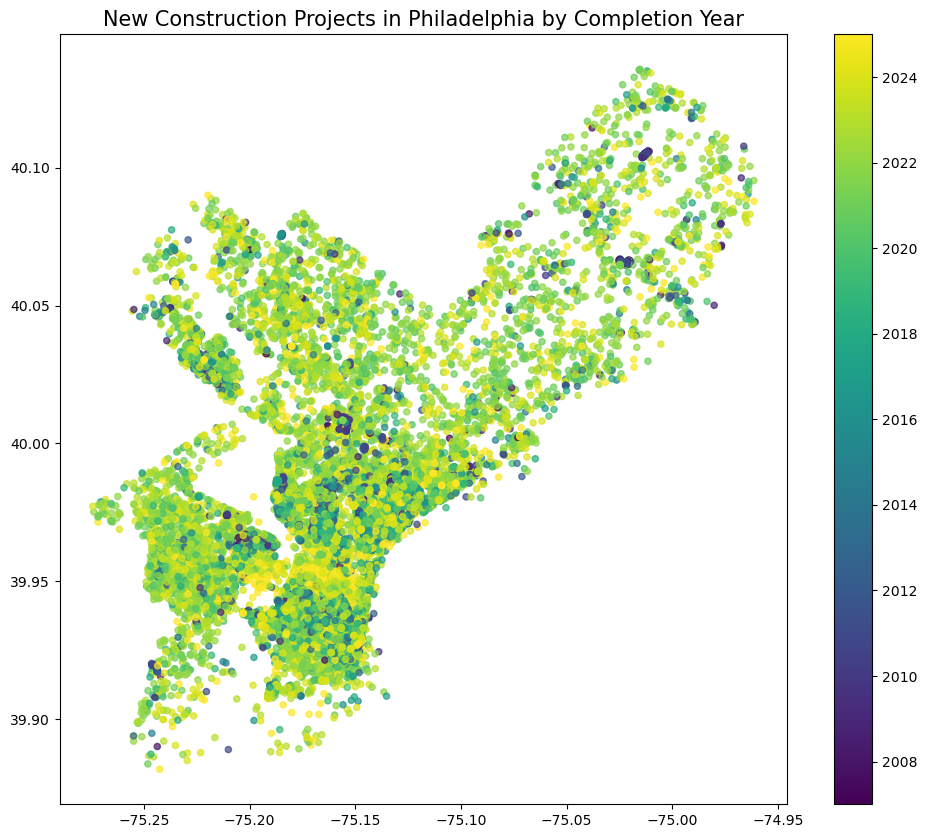

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

geo_subset = permits[['parcel_id_num', 'the_geom', 'permitcompleteddate']].drop_duplicates('parcel_id_num')
finishconssf = unitsbycompletion.merge(
    geo_subset[['parcel_id_num', 'the_geom']], 
    on='parcel_id_num', 
    how='left'
)

finishconssf['conscomplete'] = pd.to_datetime(finishconssf['conscomplete'], errors='coerce')
finishconssf['completion_year'] = finishconssf['conscomplete'].dt.year


gdf = gpd.GeoDataFrame(finishconssf,  geometry=gpd.GeoSeries.from_wkb(finishconssf["the_geom"]), crs=4326)


# Create the map
fig, ax = plt.subplots(figsize=(12, 10))

# Plot points colored by completion year
gdf.plot(
    column='completion_year',
    cmap='viridis',
    legend=True,
    ax=ax,
    markersize=20,
    alpha=0.7
)

# Add title and labels
plt.title('New Construction Projects in Philadelphia by Completion Year', fontsize=15)


In [11]:
finishconssf.head()

,parcel_id_num,conscomplete,the_geom,completion_year
0,-888680028,2023-10-28 18:56:30+00:00,0101000020E6100000EE04A385C7CB52C0D288FD3389F4...,2023
1,-888660469,2022-10-13 18:56:53+00:00,0101000020E61000002F3201A4E8BE52C0186A615B7E0B...,2022
2,-888300924,2021-07-15 15:00:49+00:00,0101000020E610000057A6CC43CBCB52C0D0ECD9C4D6F8...,2021
3,-888300920,2021-03-24 15:49:57+00:00,0101000020E610000057A6CC43CBCB52C0D0ECD9C4D6F8...,2021
4,-888300804,2023-04-03 16:44:42+00:00,0101000020E610000057A6CC43CBCB52C0D0ECD9C4D6F8...,2023


Text(0.5, 1.0, 'New Construction Density in Philadelphia')

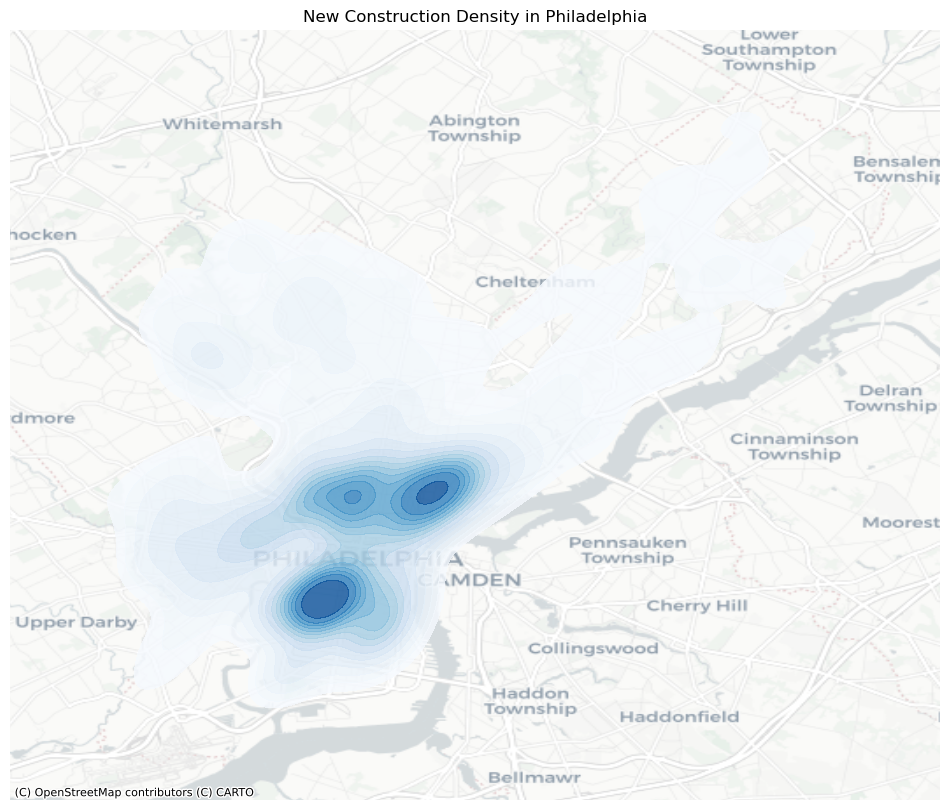

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import contextily as ctx

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

gdf_projected = gdf.to_crs('EPSG:3857')

# Get the coordinates for the KDE
x = gdf_projected.geometry.x
y = gdf_projected.geometry.y

# Create a custom colormap (from light to dark blue)
colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]
cmap = LinearSegmentedColormap.from_list("blue_density", colors)

# Create and plot the KDE
kde = sns.kdeplot(
    x=x, 
    y=y,
    fill=True,
    alpha=0.8,
    cmap=cmap,
    levels=15,
    thresh=0.05,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('New Construction Density in Philadelphia')

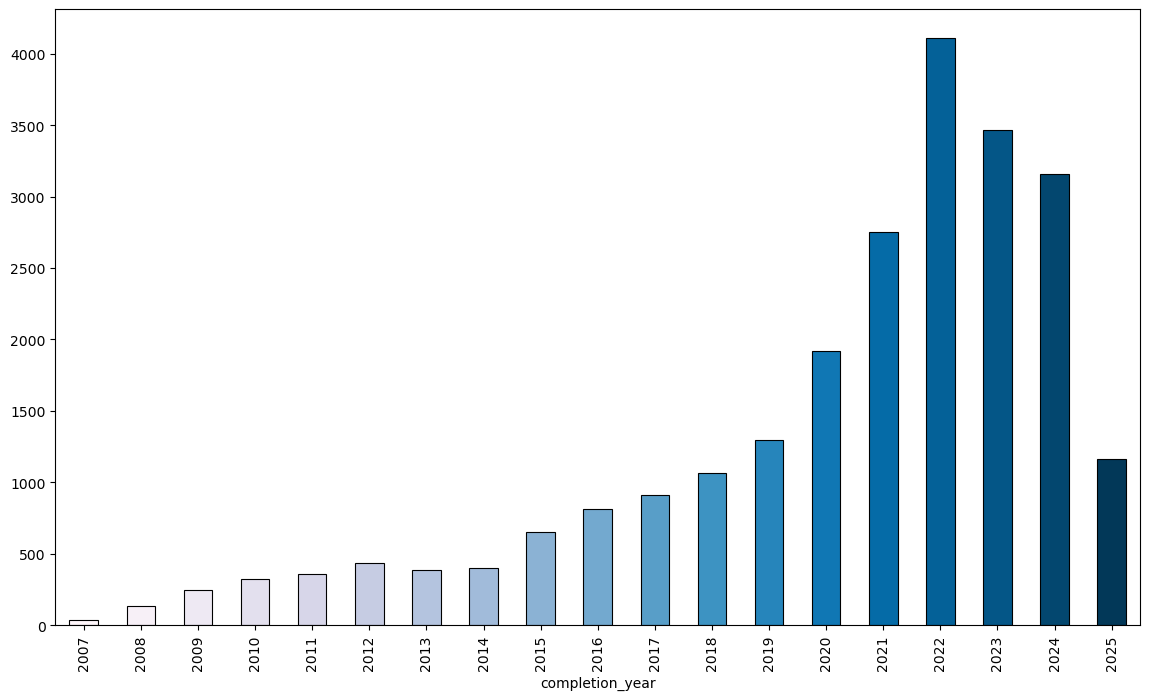

In [29]:
plt.figure(figsize=(14, 8))

# Count projects by year
yearly_counts = gdf.groupby('completion_year').size()

# Create color gradient for bars matching the map
year_colors = plt.cm.PuBu(np.linspace(0, 1, len(yearly_counts)))

# Plot with enhanced style
ax = yearly_counts.plot(
    kind='bar',
    color=year_colors,
    edgecolor='black',
    linewidth=0.8
)

In [30]:
yearly_counts.head()

completion_year
2007     33
2008    137
2009    245
2010    325
2011    356
dtype: int64

In [31]:
yearly_counts = pd.DataFrame(yearly_counts).reset_index()
yearly_counts.head()

,completion_year,0
0,2007,33
1,2008,137
2,2009,245
3,2010,325
4,2011,356


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import imageio
from matplotlib.colors import Normalize
import os
from tqdm import tqdm

def create_construction_animation(gdf, output_filename='construction_by_year.gif', fps=1):
    # Get the range of years
    min_year = int(gdf['completion_year'].min())
    max_year = int(gdf['completion_year'].max())
    years = range(min_year, max_year + 1)
    
    # Create a directory for temporary image files
    temp_dir = 'temp_frames'
    os.makedirs(temp_dir, exist_ok=True)
    
    # Setup colormap normalization based on full year range
    norm = Normalize(vmin=min_year, vmax=max_year)
    
    # Create a frame for each year
    filenames = []
    
    for year in tqdm(years, desc="Generating frames"):
        # Create a new figure for each frame
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Plot the basemap/background (just the outline of all points)
        gdf.plot(color='lightgrey', ax=ax, markersize=10, alpha=0.2)
        
        # Plot points for the current year and all previous years
        year_mask = gdf['completion_year'] <= year
        current_gdf = gdf[year_mask]
        
        if not current_gdf.empty:
            current_gdf.plot(
                column='completion_year',
                cmap='viridis',
                norm=norm,  # Use the consistent normalization
                legend=True,
                ax=ax,
                markersize=20,
                alpha=0.7
            )
        
        # Add title with the current year
        plt.title(f'New Construction Projects in Philadelphia through {year}', fontsize=15)
        
        # Add a text annotation showing the current year prominently
        plt.annotate(f'Year: {year}', xy=(0.02, 0.05), xycoords='figure fraction', 
                     fontsize=16, fontweight='bold', color='black',
                     bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
        # Save the frame
        filename = f'{temp_dir}/frame_{year}.png'
        plt.savefig(filename, dpi=100, bbox_inches='tight')
        plt.close(fig)
        filenames.append(filename)
    
    # Create a GIF from the saved frames
    with imageio.get_writer(output_filename, mode='I', fps=fps, loop=0) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    # Optional: Clean up temporary files
    for filename in filenames:
        os.remove(filename)
    os.rmdir(temp_dir)
    
    print(f"Animation saved as {output_filename}")
    return output_filename

# Example usage:
create_construction_animation(gdf, output_filename='philadelphia_construction.gif', fps=1)

Generating frames: 100%|██████████| 19/19 [00:30<00:00,  1.62s/it]
/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_22330/1070265410.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Animation saved as philadelphia_construction.gif


'philadelphia_construction.gif'

In [32]:
gdf.head()

,parcel_id_num,conscomplete,the_geom,completion_year,geometry
0,-888680028,2023-10-28 18:56:30+00:00,0101000020E6100000EE04A385C7CB52C0D288FD3389F4...,2023,POINT (-75.18405 39.91044)
1,-888660469,2022-10-13 18:56:53+00:00,0101000020E61000002F3201A4E8BE52C0186A615B7E0B...,2022,POINT (-74.98295 40.08979)
2,-888300924,2021-07-15 15:00:49+00:00,0101000020E610000057A6CC43CBCB52C0D0ECD9C4D6F8...,2021,POINT (-75.18428 39.94405)
3,-888300920,2021-03-24 15:49:57+00:00,0101000020E610000057A6CC43CBCB52C0D0ECD9C4D6F8...,2021,POINT (-75.18428 39.94405)
4,-888300804,2023-04-03 16:44:42+00:00,0101000020E610000057A6CC43CBCB52C0D0ECD9C4D6F8...,2023,POINT (-75.18428 39.94405)


In [36]:
gdf=gdf.drop(columns=['conscomplete'])

In [37]:
gdf.to_file("philadelphia_construction.shp", driver='ESRI Shapefile')

C:\Users\cnmit\AppData\Local\Temp\ipykernel_20992\4183159089.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("philadelphia_construction.shp", driver='ESRI Shapefile')


In [ ]:
districts = gpd.read_file('https://opendata.arcgis.com/api/v3/datasets/1ba5a5d68f4a4c75806e78b1d9245924_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1')

In [ ]:
cons_dist = gpd.sjoin(gdf, districts, how='left', predicate='intersects')
dist_cons = cons_dist.groupby('DISTRICT').size().reset_index(name='count')
dist_cons.head()

,DISTRICT,count
0,1,4038
1,10,729
2,2,4753
3,3,2273
4,4,1576


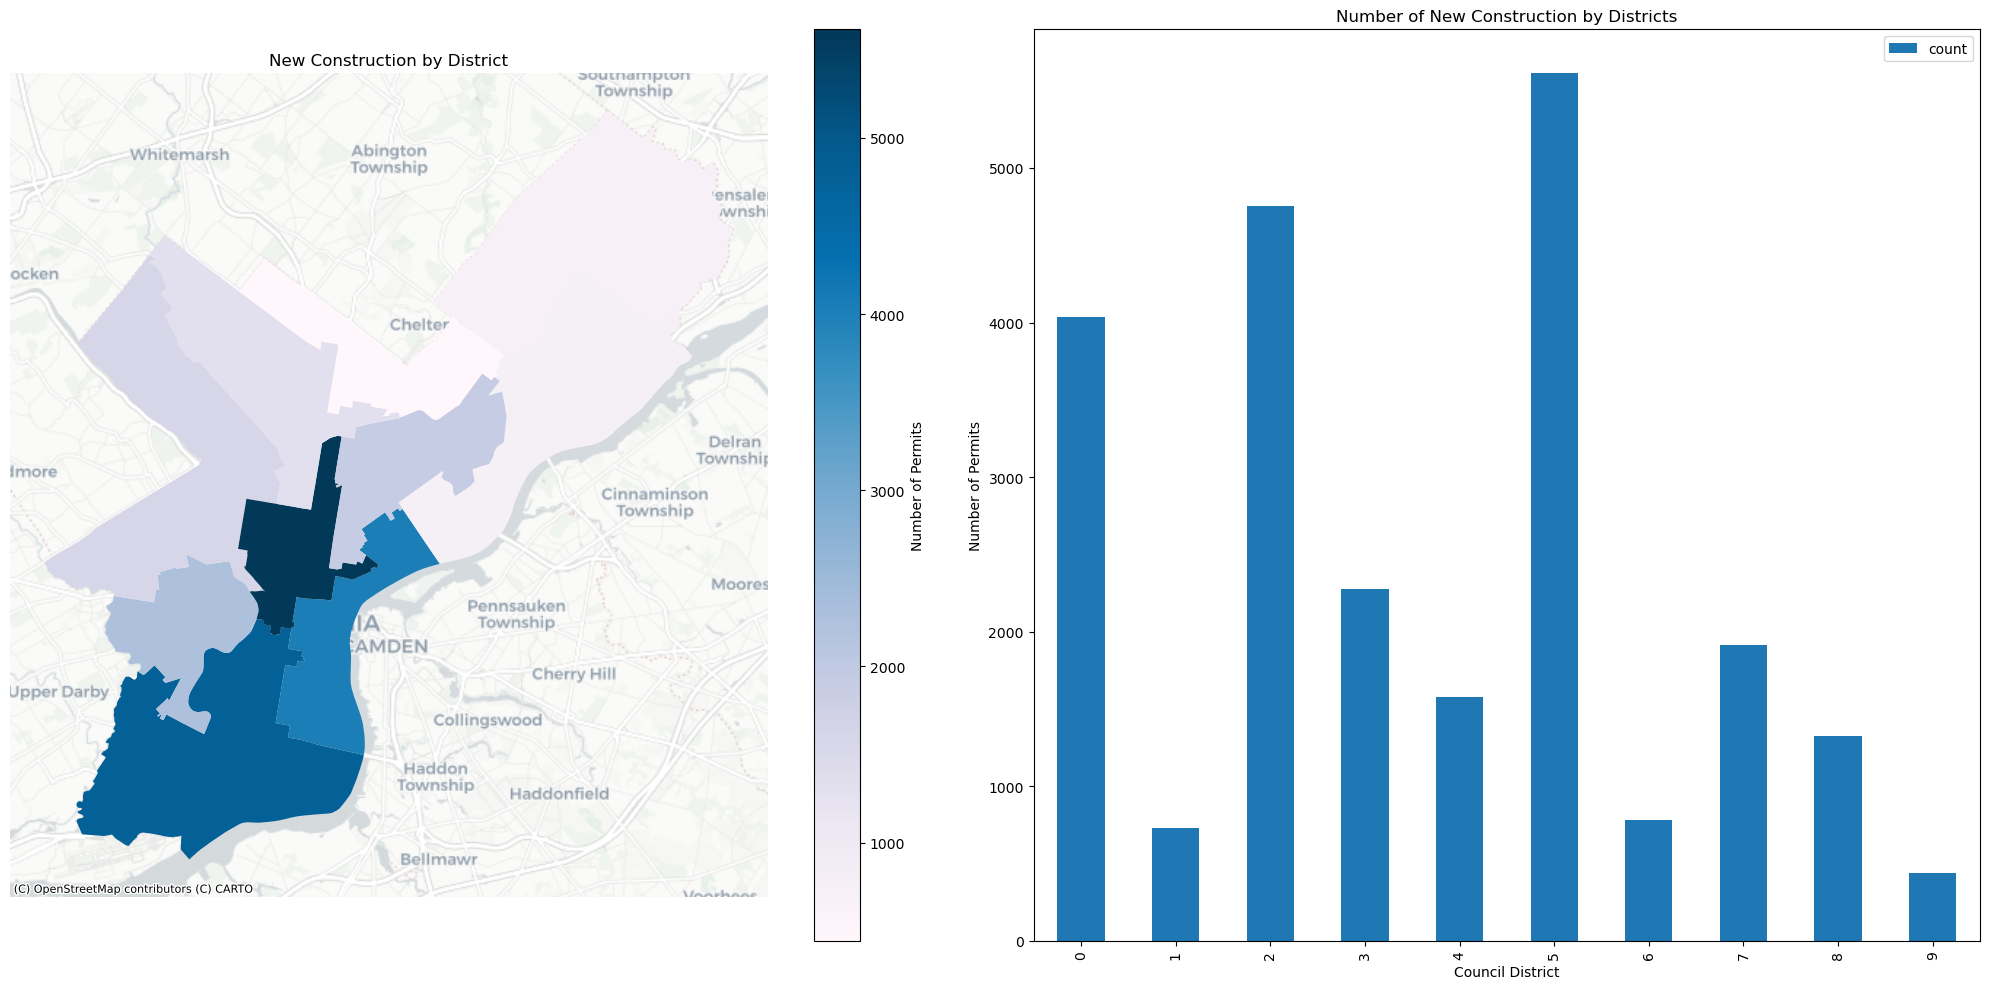

In [ ]:
from shapely.geometry import Point
import contextily as ctx

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

merged_data = districts.merge(dist_cons, on='DISTRICT', how='left')
merged_data = merged_data.to_crs(epsg=3857)
merged_data.plot(column='count', 
                ax=ax1,
                legend=True,
                cmap='PuBu',
                legend_kwds={'label': 'Number of Permits'},
                missing_kwds={'color': 'lightgrey'})

# Basemap
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
ax1.set_axis_off()
ax1.set_title('New Construction by District')

# Bar chart of change of use permits by district
dist_cons.plot(kind='bar', ax=ax2)
ax2.set_title('Number of New Construction by Districts')
ax2.set_xlabel('Council District')
ax2.set_ylabel('Number of Permits')

plt.tight_layout()
plt.show()

## Adaptive Reuse

In [ ]:
# Adaptive Reuse related words, entire structure work but no new construction
adaptwork = [
    'ENTSTR','ENTIRE'
]

# filerting
adaptconsprops = permits[
    permits['typeofwork'].isin(adaptwork)
]

In [ ]:
adaptunits = permits[permits['parcel_id_num'].isin(newconsprops['parcel_id_num'])].groupby('parcel_id_num')['permitcompleteddate'].max().reset_index()
adaptunits = adaptunits.rename(columns={'permitcompleteddate': 'conscomplete'})
adaptunits.head()

,parcel_id_num,conscomplete
0,-888680028,2023-10-28T18:56:30Z
1,-888660469,2022-10-13T18:56:53Z
2,-888300924,2021-07-15T15:00:49Z
3,-888300920,2021-03-24T15:49:57Z
4,-888300804,2023-04-03T16:44:42Z


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

finishadapt = adaptunits.merge(
    geo_subset[['parcel_id_num', 'the_geom']], 
    on='parcel_id_num', 
    how='left'
)

finishadapt['conscomplete'] = pd.to_datetime(finishadapt['conscomplete'], errors='coerce')
finishadapt['completion_year'] = finishadapt['conscomplete'].dt.year


gdfadapt = gpd.GeoDataFrame(finishadapt,  geometry=gpd.GeoSeries.from_wkb(finishadapt["the_geom"]), crs=4326)

Text(0.5, 1.0, 'Adaptive Reuse Density in Philadelphia')

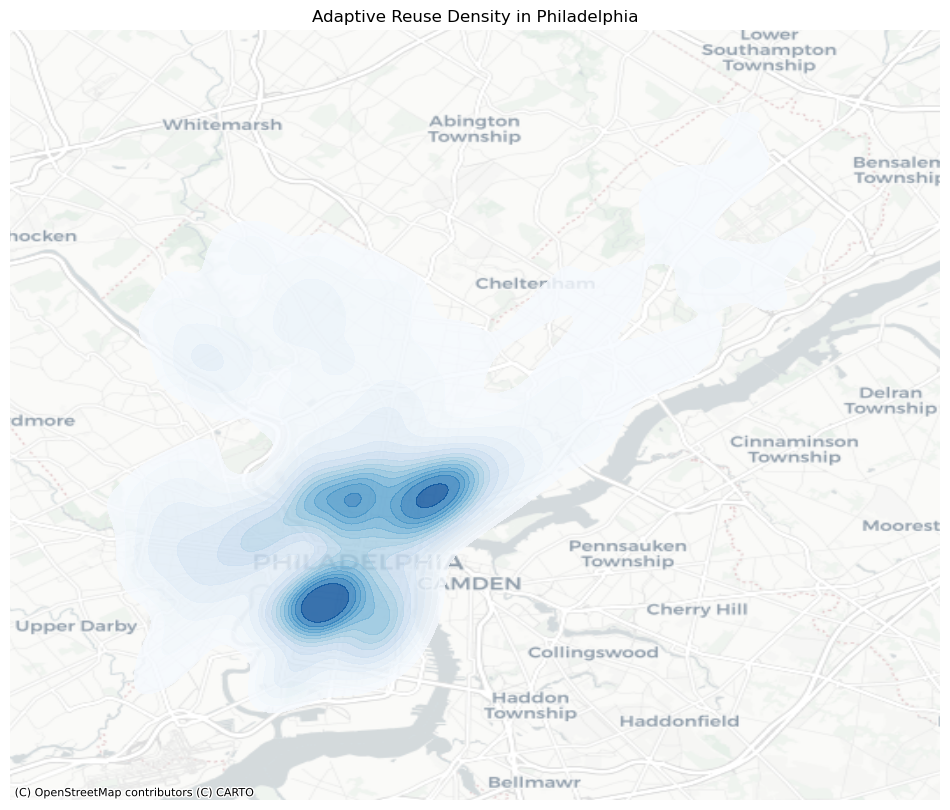

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import contextily as ctx

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

adaptprog = gdfadapt.to_crs('EPSG:3857')

# Get the coordinates for the KDE
x = adaptprog.geometry.x
y = adaptprog.geometry.y

# Create a custom colormap (from light to dark blue)
colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]
cmap = LinearSegmentedColormap.from_list("blue_density", colors)

# Create and plot the KDE
kde = sns.kdeplot(
    x=x, 
    y=y,
    fill=True,
    alpha=0.8,
    cmap=cmap,
    levels=15,
    thresh=0.05,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('Adaptive Reuse Density in Philadelphia')

/opt/homebrew/Caskroom/mambaforge/base/envs/practicumenv/lib/python3.11/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


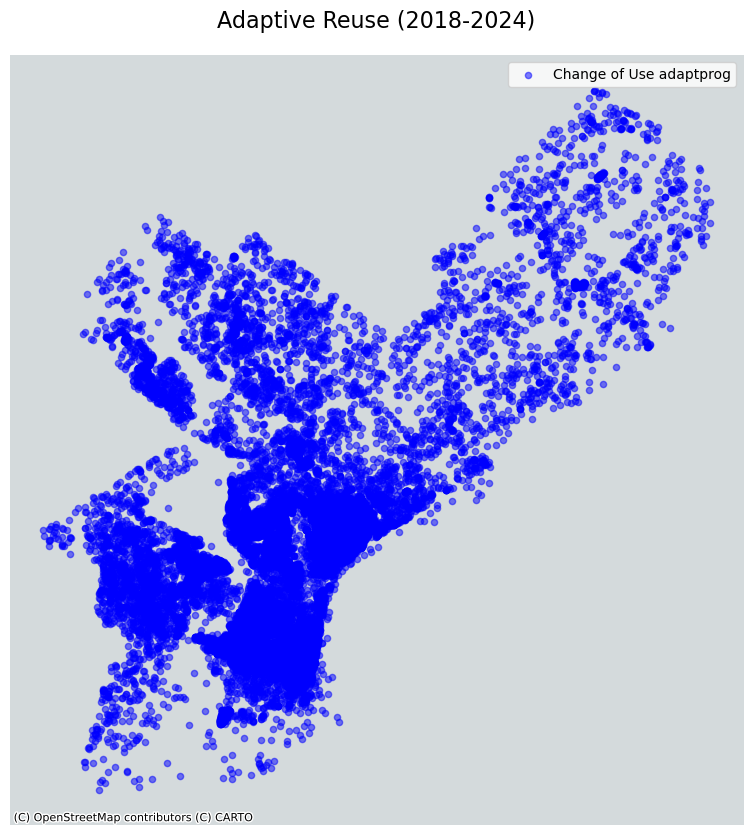

In [ ]:
# Create a figure and axis first
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the adaptive reuse points
gdfadapt.plot(ax=ax, 
             alpha=0.5, 
             c='blue',
             markersize=20,
             label='Change of Use adaptprog')

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Plot customization
plt.title('Adaptive Reuse (2018-2024)', fontsize=16, pad=20)
ax.set_axis_off()
plt.legend()  # Add a legend for the blue points

plt.show()

Text(0.5, 1.0, 'Adaptive Reuse by District')

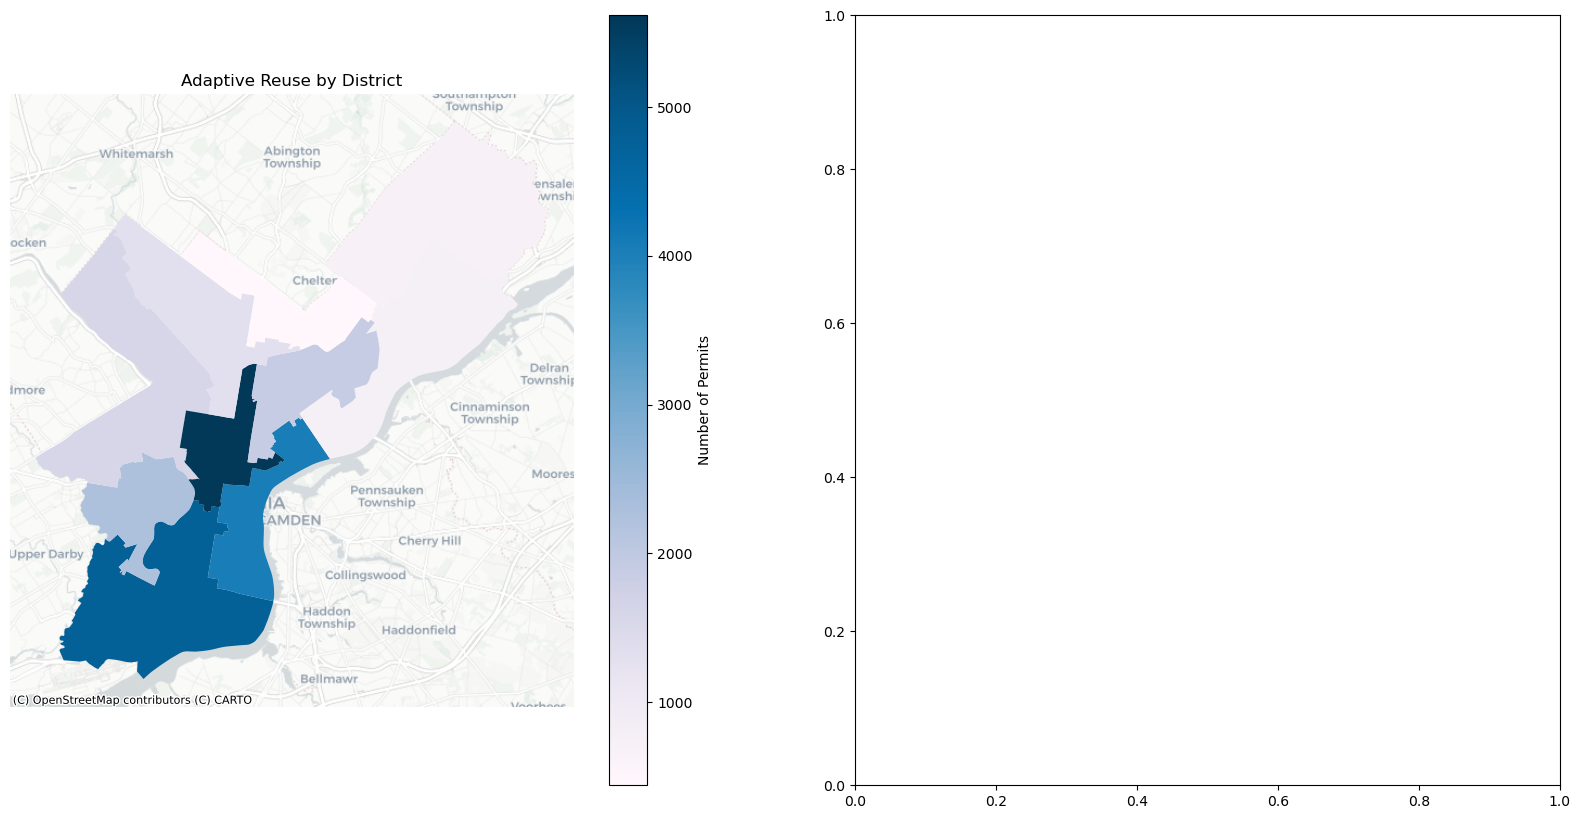

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

adaptdist = gpd.sjoin(gdfadapt, districts, how='left', predicate='intersects')
distadapt = adaptdist.groupby('DISTRICT').size().reset_index(name='count')

adaptmerge = districts.merge(distadapt, on='DISTRICT', how='left')

# Set the active geometry column after merging
adaptmerge = adaptmerge.set_geometry('geometry')  # Choose the appropriate geometry column

adaptmerge = adaptmerge.to_crs(epsg=3857)
adaptmerge.plot(column='count', 
                ax=ax1,
                legend=True,
                cmap='PuBu',
                legend_kwds={'label': 'Number of Permits'},
                missing_kwds={'color': 'lightgrey'})

# Basemap
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
ax1.set_axis_off()
ax1.set_title('Adaptive Reuse by District')